In [1]:
import pandas as pd
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import kendalltau
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from xgboost import XGBRegressor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# 1.  Завантажте базу даних меблів ІКЕА.

def fetch_data(url, required_columns=None):
    try:
        response = requests.get(url, timeout=10)  # Додаємо обмеження часу (10 сек)
        response.raise_for_status()

        data = pd.read_csv(StringIO(response.text))

        if not isinstance(data, pd.DataFrame):
            raise ValueError("Помилка! Дані не були коректно завантажені.")

        if required_columns:
            missing_columns = [col for col in required_columns if col not in data.columns]
            if missing_columns:
                print(f"⚠️ Відсутні необхідні колонки: {', '.join(missing_columns)}")

        print("✅ Дані успішно завантажено та перевірено!")
        return data

    except requests.exceptions.Timeout:
        print("❌ Запит перевищив ліміт часу. Спробуйте ще раз.")
    except requests.exceptions.RequestException as e:
        print(f"❌ Помилка запиту: {e}")
    except Exception as e:
        print(f"❌ Виникла помилка: {e}")

    return None

In [3]:
# URL набору даних

link = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv"
data = fetch_data(link)

if data is not None:
    print(data.head())  # Вивід перших рядків для перевірки
else:
    print("❌ Дані не завантажено.")

✅ Дані успішно завантажено та перевірено!
   Unnamed: 0   item_id                   name       category   price  \
0           0  90420332               FREKVENS  Bar furniture   265.0   
1           1    368814              NORDVIKEN  Bar furniture   995.0   
2           2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3           3  80155205                   STIG  Bar furniture    69.0   
4           4  30180504                NORBERG  Bar furniture   225.0   

      old_price  sellable_online  \
0  No old price             True   
1  No old price            False   
2  No old price            False   
3  No old price             True   
4  No old price             True   

                                                link other_colors  \
0  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...           No   
1  https://www.ikea.com/sa/en/p/nordviken-bar-tab...           No   
2  https://www.ikea.com/sa/en/p/nordviken-nordvik...           No   
3  https://www.ikea.com/sa

In [4]:
# Перегляд колонок у наборі даних

if data is not None:
    print(data.columns)
else:
    print("Дані не завантажено")

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')


In [5]:
# Перевірка перших рядків завантажених даних з параметром кількості рядків

def check_loaded_data(data, n=5):
    if isinstance(data, pd.DataFrame):  # Перевіряємо, чи це DataFrame
        print(f"✅ Дані успішно завантажено! Розмір: {data.shape[0]} рядків, {data.shape[1]} колонок")
        print(data.head(n).to_markdown(index=False))
    else:
        print("❌ Дані не завантажено або некоректний формат.")

# Виклик функції для перевірки
check_loaded_data(data, n=10)  # Перевіряємо перші 10 рядків

✅ Дані успішно завантажено! Розмір: 3694 рядків, 14 колонок
|   Unnamed: 0 |   item_id | name                  | category      |   price | old_price    | sellable_online   | link                                                                                                              | other_colors   | short_description                                 | designer             |   depth |   height |   width |
|-------------:|----------:|:----------------------|:--------------|--------:|:-------------|:------------------|:------------------------------------------------------------------------------------------------------------------|:---------------|:--------------------------------------------------|:---------------------|--------:|---------:|--------:|
|            0 |  90420332 | FREKVENS              | Bar furniture |     265 | No old price | True              | https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                                        | No  

In [6]:
# 2. Описова статистика та візуалізація даних

# Очищення даних

if data is not None:
    print("🔍 Початок очистки даних...")

    # ✅ Захист важливих колонок
    required_columns = ['other_colors', 'price', 'designer', 'depth', 'height', 'width']
    category_columns = [col for col in data.columns if col.startswith('category_')]
    all_columns_to_preserve = required_columns + category_columns
    
    # ✅ Перевірка наявності ключових колонок
    missing_columns = [col for col in all_columns_to_preserve if col not in data.columns]
    if missing_columns:
        print(f"⚠️ Увага! Відсутні важливі колонки: {', '.join(missing_columns)}")
    else:
        print("✅ Усі необхідні колонки присутні.")

    # ✅ Видалення повних дублікатів
    initial_row_count = data.shape[0]
    data = data.drop_duplicates()
    print(f"🧹 Видалено {initial_row_count - data.shape[0]} повних дублікатів.")

    # ✅ Видалення дублікатів за item_id (якщо колонка існує)
    if 'item_id' in data.columns:
        initial_row_count = data.shape[0]
        data['item_id'] = data['item_id'].astype(str)  # Перетворення item_id у строку
        data = data.drop_duplicates(subset=['item_id'], keep='first')
        print(f"🔄 Видалено {initial_row_count - data.shape[0]} сутнісних дублікатів по item_id.")

    # ✅ Видалення нерелевантних колонок
    drop_columns = ['name', 'link', 'short_description', 'sellable_online', 'item_id', 'old_price']
    data_cleaned = data.drop(columns=drop_columns, errors='ignore')

    # ✅ Створення 'category_designer'
    if 'category' in data_cleaned.columns and 'designer' in data_cleaned.columns:
        data_cleaned['category_designer'] = data_cleaned['category'].astype(str) + "_" + data_cleaned['designer'].astype(str)

    # ✅ Перевірка стану після очистки
    preserved_columns = [col for col in all_columns_to_preserve if col in data_cleaned.columns]
    print(f"✅ Збережені колонки після очистки: {', '.join(preserved_columns)}")

    print("🎯 Дані очищені та готові до аналізу!")
else:
    print("❌ Дані не завантажено. Перевірте джерело.")

🔍 Початок очистки даних...
✅ Усі необхідні колонки присутні.
🧹 Видалено 0 повних дублікатів.
🔄 Видалено 732 сутнісних дублікатів по item_id.
✅ Збережені колонки після очистки: other_colors, price, designer, depth, height, width
🎯 Дані очищені та готові до аналізу!


🔎 Початок аналізу викидів...
✅ Усі необхідні колонки присутні.


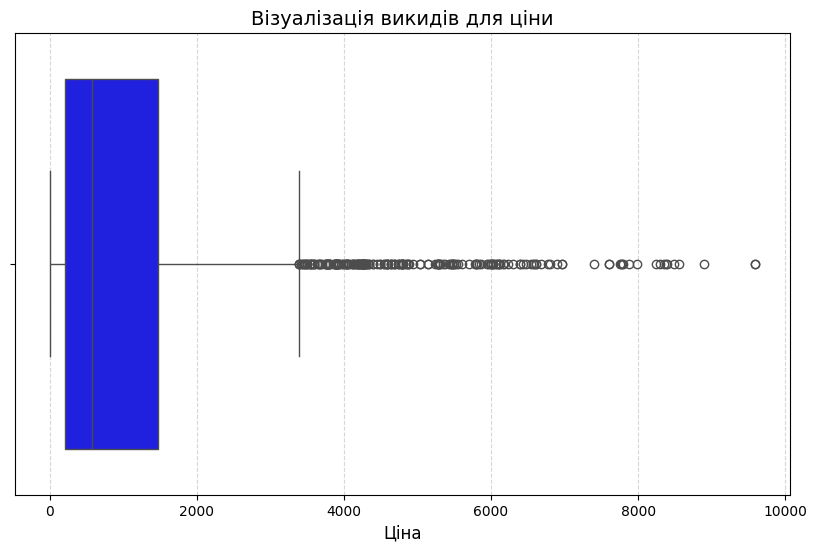

🔍 Кількість викидів у 'price': 219
🔎 Кількість викидів у 'depth': 112
🔎 Кількість викидів у 'height': 148
🔎 Кількість викидів у 'width': 88
🎯 Аналіз викидів завершено!


In [7]:
if data is not None:
    print("🔎 Початок аналізу викидів...")

    # Перевірка наявності важливих колонок
    required_columns = ['other_colors', 'price', 'designer', 'depth', 'height', 'width']
    category_columns = [col for col in data.columns if col.startswith('category_')]
    all_columns_to_preserve = required_columns + category_columns
    
    missing_columns = [col for col in all_columns_to_preserve if col not in data.columns]
    if missing_columns:
        print(f"⚠️ Відсутні необхідні колонки: {', '.join(missing_columns)}")
    else:
        print("✅ Усі необхідні колонки присутні.")

    # Візуалізація викидів для ціни
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['price'], color='blue')
    plt.title('Візуалізація викидів для ціни', fontsize=14)
    plt.xlabel('Ціна', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

    # Видалення викидів на основі меж квартилів
    Q1 = data['price'].quantile(0.25)
    Q3 = data['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Аналіз викидів без видалення
    outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
    print(f"🔍 Кількість викидів у 'price': {outliers.shape[0]}")

    # Додаткова перевірка викидів для габаритів (depth, height, width)
    for column in ['depth', 'height', 'width']:
        if column in data.columns:
            Q1_col = data[column].quantile(0.25)
            Q3_col = data[column].quantile(0.75)
            IQR_col = Q3_col - Q1_col
            lower_bound_col = Q1_col - 1.5 * IQR_col
            upper_bound_col = Q3_col + 1.5 * IQR_col
            
            outliers_col = data[(data[column] < lower_bound_col) | (data[column] > upper_bound_col)]
            print(f"🔎 Кількість викидів у '{column}': {outliers_col.shape[0]}")

    print("🎯 Аналіз викидів завершено!")

else:
    print("❌ Дані не завантажено. Перевірте джерело.")

🔎 Початок аналізу викидів для габаритів...
✅ Усі необхідні колонки присутні.


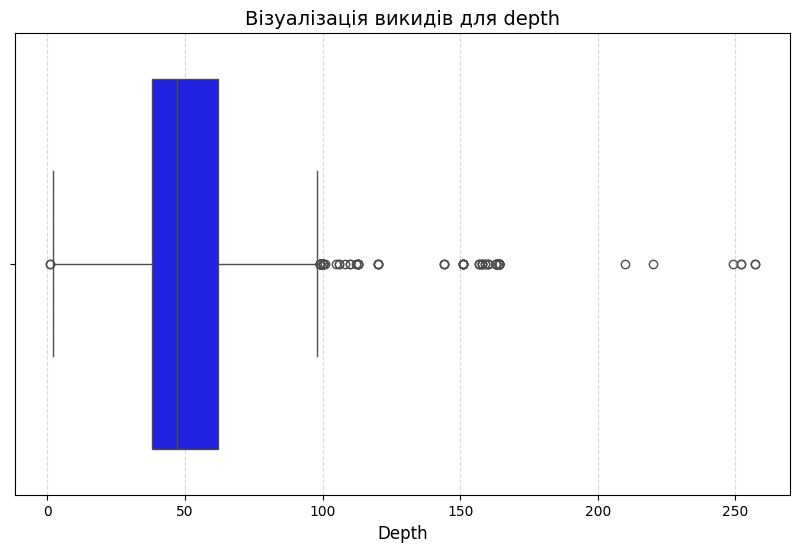

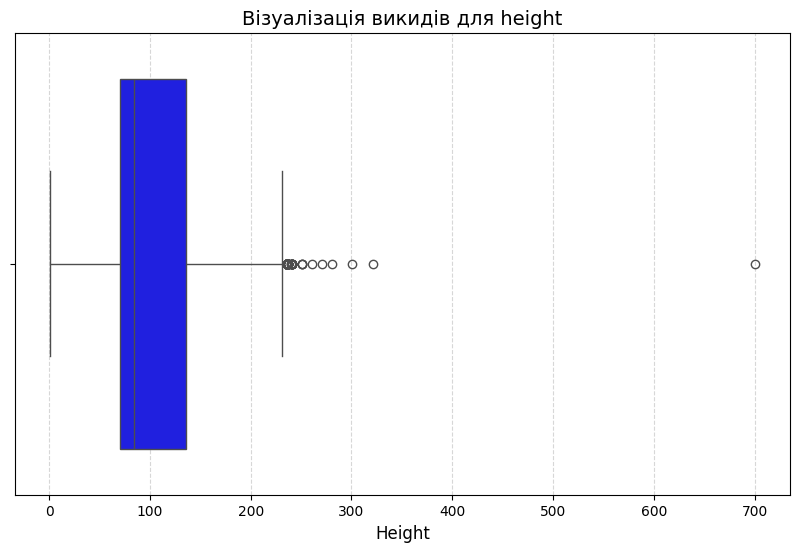

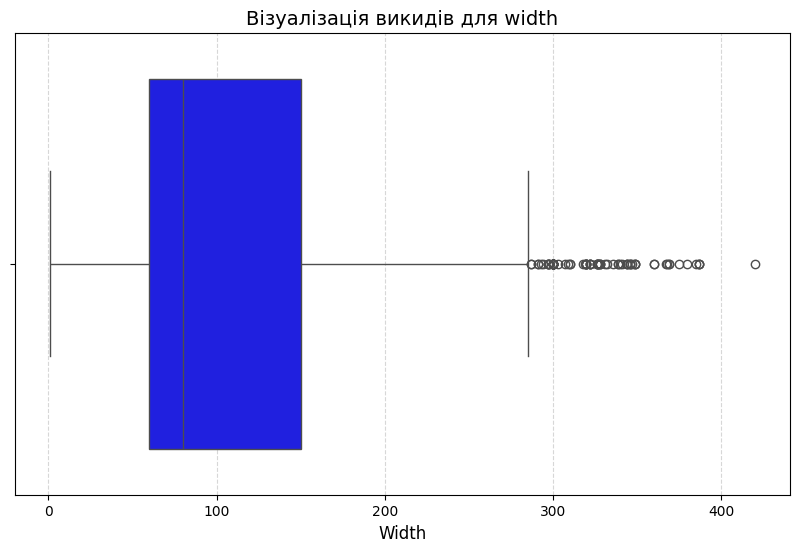

🔎 Кількість викидів у 'depth': 112
🔎 Кількість викидів у 'height': 148
🔎 Кількість викидів у 'width': 88
🎯 Аналіз викидів завершено!


In [8]:
if data is not None:
    
    print("🔎 Початок аналізу викидів для габаритів...")

    # Перевірка, чи всі необхідні числові колонки доступні
    dimension_columns = ['depth', 'height', 'width']
    missing_dimensions = [col for col in dimension_columns if col not in data.columns]
    
    if missing_dimensions:
        print(f"⚠️ Відсутні важливі колонки: {', '.join(missing_dimensions)}")
    else:
        print("✅ Усі необхідні колонки присутні.")

    # Візуалізація викидів для кожної змінної
    for column in dimension_columns:
        if column in data.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[column], color='blue')
            plt.title(f'Візуалізація викидів для {column}', fontsize=14)
            plt.xlabel(column.capitalize(), fontsize=12)
            plt.grid(axis='x', linestyle='--', alpha=0.5)
            plt.show()

    # Виділення викидів для кожного параметра окремо
    outlier_counts = {}  # Словник для підрахунку викидів
    outliers_data = {}  # Словник для збереження об'єктів з викидами

    for column in dimension_columns:
        if column in data.columns:
            Q1_col = data[column].quantile(0.25)
            Q3_col = data[column].quantile(0.75)
            IQR_col = Q3_col - Q1_col
            lower_bound_col = Q1_col - 1.5 * IQR_col
            upper_bound_col = Q3_col + 1.5 * IQR_col

            outliers_col = data[(data[column] < lower_bound_col) | (data[column] > upper_bound_col)]
            outlier_counts[column] = outliers_col.shape[0]
            outliers_data[column] = outliers_col  # Збереження викидів

    # Вивід підсумків
    for column, count in outlier_counts.items():
        print(f"🔎 Кількість викидів у '{column}': {count}")

    print("🎯 Аналіз викидів завершено!")

else:
    print("❌ Дані не завантажено. Перевірте джерело.")

In [9]:
if data is not None:
    print("🔍 Початок аналізу пропущених значень...")

    # Аналіз пропущених значень
    missing_values = data.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Відображати лише колонки з пропусками
    print(missing_values.to_markdown())

    # Заповнення пропущених значень
    if 'designer' in data.columns:
        data['designer'] = data['designer'].fillna('Unknown')  # Заповнення для дизайнерів
        print("✅ Пропущені значення у 'designer' заповнені.")

    # Перетворення категоріальних змінних (оновлення для колонок `category_*`)
    category_columns = [col for col in data.columns if col.startswith('category_')]
    if category_columns:
        print(f"✅ Категорії виявлено: {', '.join(category_columns)}")
    else:
        print("⚠️ Категорійні колонки не знайдено.")

    # Видалення зайвих колонок **без видалення важливих змінних**
    unnecessary_columns = ['link', 'short_description']  # 'other_colors' НЕ ВИДАЛЯЄМО!
    preserved_columns = [col for col in data.columns if col not in unnecessary_columns]

    data = data[preserved_columns]
    print(f"🔹 Збережені колонки після очистки: {', '.join(preserved_columns)}")

    print("🎯 Очищення завершено! Дані готові до аналізу.")

else:
    print("❌ Дані не завантажено. Перевірте джерело.")

🔍 Початок аналізу пропущених значень...
|        |    0 |
|:-------|-----:|
| depth  | 1118 |
| height |  726 |
| width  |  442 |
✅ Пропущені значення у 'designer' заповнені.
⚠️ Категорійні колонки не знайдено.
🔹 Збережені колонки після очистки: Unnamed: 0, item_id, name, category, price, old_price, sellable_online, other_colors, designer, depth, height, width
🎯 Очищення завершено! Дані готові до аналізу.


In [10]:
if data is not None:

    print("🔍 Початок очищення колонки 'old_price'...")

    def clean_column(column):
        return column.apply(lambda x: (
            np.nan if isinstance(x, str) and x.lower() == 'no old price' else
            str(x).replace(',', '.').replace('SR', '').replace('/', '.').replace('pack', '').strip()
        ))

    # Перевірка, чи колонка 'old_price' існує
    if 'old_price' in data.columns:
        data['old_price'] = clean_column(data['old_price'])
        data['old_price'] = pd.to_numeric(data['old_price'], errors='coerce')  # Перетворення у числовий формат
        print("✅ Очистка 'old_price' завершена. Дані конвертовані у числовий формат.")

    else:
        print("⚠️ Колонка 'old_price' відсутня у наборі даних.")

else:
    print("❌ Дані не завантажено. Перевірте джерело.")

🔍 Початок очищення колонки 'old_price'...
✅ Очистка 'old_price' завершена. Дані конвертовані у числовий формат.


In [11]:
if data is not None:
    print("🔍 Початок очищення колонки 'designer'...")

    def clean_designers(value, remove_ikea=False, empty_value=np.nan):
        if not isinstance(value, str):
            return empty_value
        
        value = value.strip()  # Прибираємо зайві пробіли
        if value and value[0].isdigit():  # Якщо значення починається з цифри, вважаємо його некоректним
            return empty_value
        
        designers = [d.strip() for d in value.split("/") if d.strip()]  # Очистка кожного значення
        
        if remove_ikea:
            designers = [d for d in designers if d.lower() != "ikea of sweden"]  # Видалення IKEA
        
        return '/'.join(sorted(designers)) if designers else empty_value  # Сортування дизайнерів
    
    # Перевірка, чи колонка 'designer' існує
    if 'designer' in data.columns:
        data['designer'] = data['designer'].apply(clean_designers)
        print("✅ Очистка 'designer' завершена.")
    else:
        print("⚠️ Колонка 'designer' відсутня у наборі даних.")

else:
    print("❌ Дані не завантажено. Перевірте джерело.")

🔍 Початок очищення колонки 'designer'...
✅ Очистка 'designer' завершена.


In [12]:
if data is not None:

    print("🔍 Початок очищення колонки 'short_description'...")

    # Перевірка, чи колонка 'short_description' існує
    if 'short_description' in data.columns:
        # Очищення тексту: збереження лише алфавітних символів, цифр і пробілів
        data['short_description'] = data['short_description'].astype(str).str.strip()
        data['short_description'] = data['short_description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
        
        # Видалення зайвих пробілів між словами
        data['short_description'] = data['short_description'].str.replace(r'\s+', ' ', regex=True)

        print("✅ Очистка 'short_description' завершена.")
    else:
        print("⚠️ Колонка 'short_description' відсутня у наборі даних.")

else:
    print("❌ Дані не завантажено. Перевірте джерело.")

🔍 Початок очищення колонки 'short_description'...
⚠️ Колонка 'short_description' відсутня у наборі даних.


C:\Users\behun\AppData\Local\Temp\ipykernel_23496\1931306350.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color_counts.index, y=color_counts.values, palette=['skyblue', 'orange'])


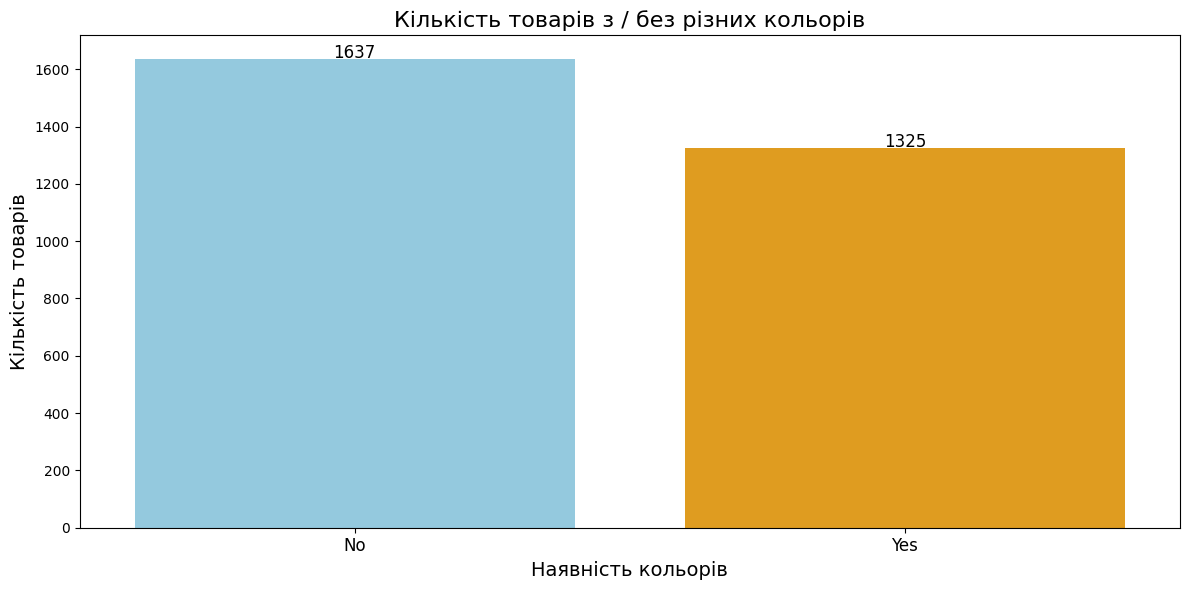

In [13]:
# Візуалізація кількості товарів з / без різних кольорів

# Перевірка, чи колонка 'other_colors' є в наборі даних
if 'other_colors' in data.columns:
    # Підрахунок кількості товарів
    color_counts = data['other_colors'].value_counts()

    # Побудова стовпчастої діаграми
    plt.figure(figsize=(12, 6))
    sns.barplot(x=color_counts.index, y=color_counts.values, palette=['skyblue', 'orange'])

    # Додавання заголовку та підписів до осей
    plt.title('Кількість товарів з / без різних кольорів', fontsize=16)
    plt.xlabel('Наявність кольорів', fontsize=14)
    plt.ylabel('Кількість товарів', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)

    # Додавання числових підписів до стовпчиків
    for index, value in enumerate(color_counts.values):
        plt.text(index, value + 3, str(value), ha='center', fontsize=12)

    # Відображення графіка
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Увага! Колонка 'other_colors' відсутня у наборі даних.")

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\3642807030.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='other_colors', y='price', data=median_price_by_color, palette=['skyblue', 'orange'])


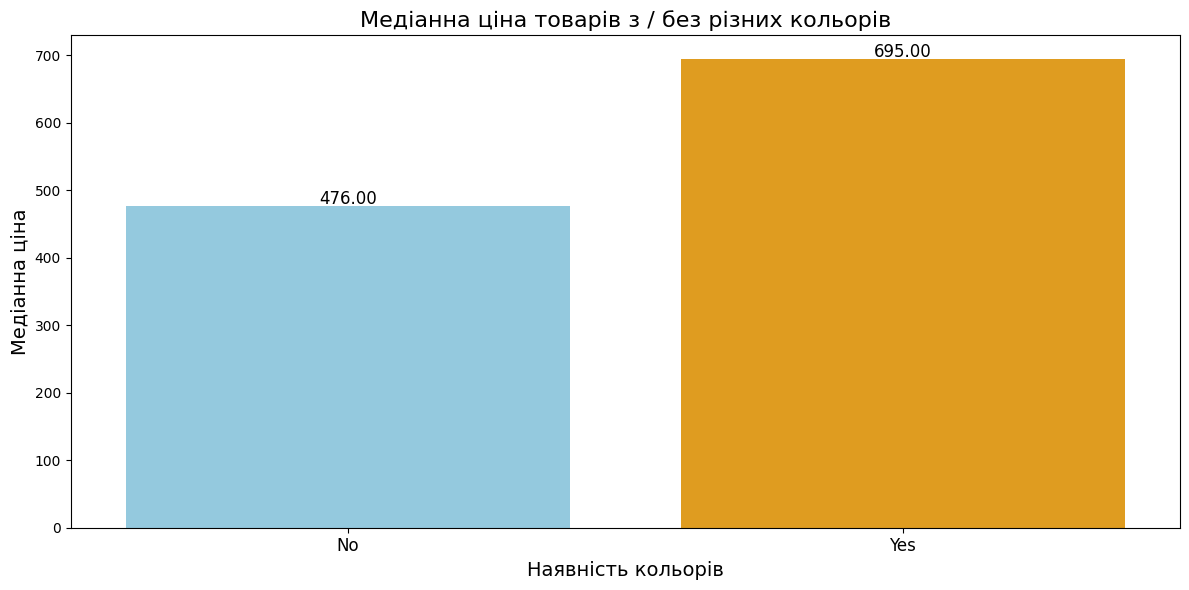

In [14]:
# Візуалізація медіанної ціни товарів з / без кольорів

# Перевірка наявності колонки 'other_colors'
if 'other_colors' in data.columns and 'price' in data.columns:
    # Розрахунок медіанної ціни
    median_price_by_color = data.groupby('other_colors')['price'].median().reset_index()

    # Візуалізація
    plt.figure(figsize=(12, 6))
    sns.barplot(x='other_colors', y='price', data=median_price_by_color, palette=['skyblue', 'orange'])

    # Додавання заголовку та підписів
    plt.title('Медіанна ціна товарів з / без різних кольорів', fontsize=16)
    plt.xlabel('Наявність кольорів', fontsize=14)
    plt.ylabel('Медіанна ціна', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)

    # Додавання числових значень на стовпці
    for index, value in enumerate(median_price_by_color['price']):
        plt.text(index, value + 3, f"{value:.2f}", ha='center', fontsize=12)

    # Відображення графіка
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Увага! Відсутня одна з необхідних колонок ('other_colors' або 'price').")

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\4123427423.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="muted")


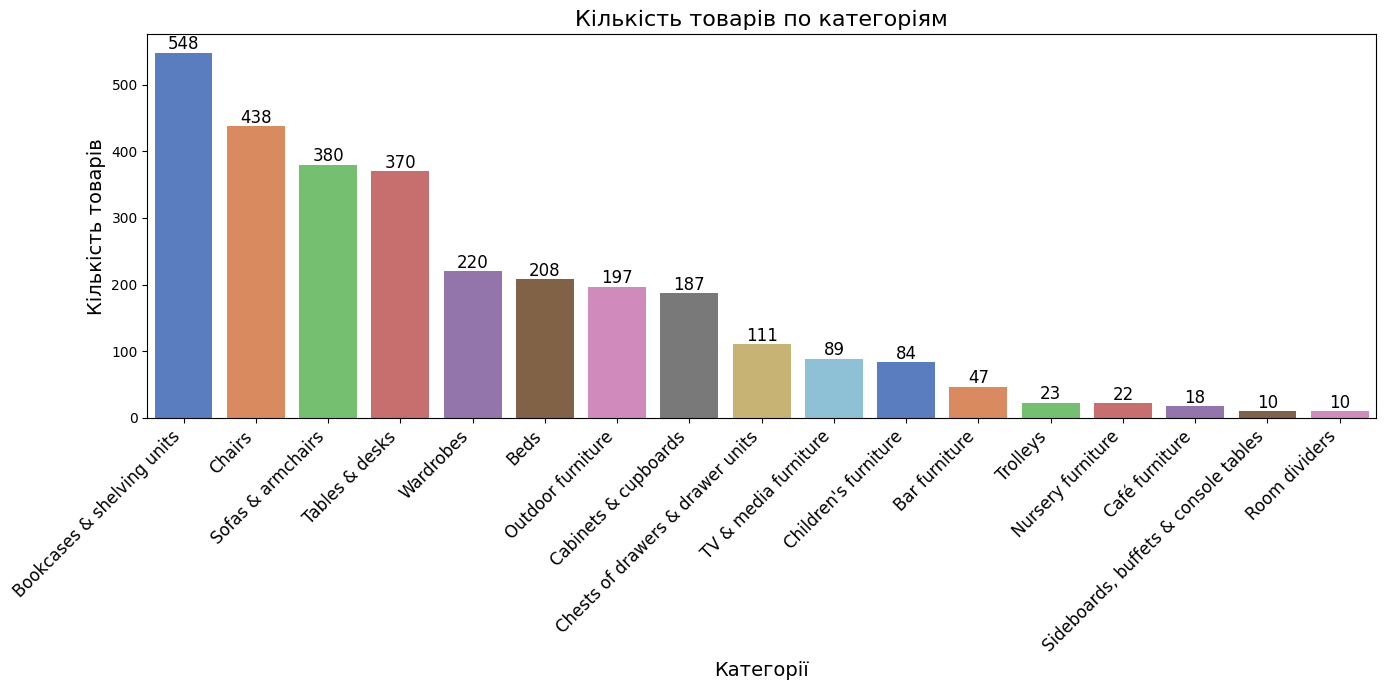

In [15]:
# Візуалізація кількості товарів по категоріям

# Перевірка наявності колонки 'category'
if 'category' in data.columns:
    # Підрахунок кількості товарів по категоріях
    category_counts = data['category'].value_counts()

    # Візуалізація
    plt.figure(figsize=(14, 7))
    sns.barplot(x=category_counts.index, y=category_counts.values, palette="muted")

    # Додавання заголовку та підписів
    plt.title('Кількість товарів по категоріям', fontsize=16)
    plt.xlabel('Категорії', fontsize=14)
    plt.ylabel('Кількість товарів', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Додавання числових значень над стовпцями
    for index, value in enumerate(category_counts.values):
        plt.text(index, value + 5, str(int(value)), ha='center', fontsize=12)

    # Відображення графіка
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Увага! Колонка 'category' відсутня у наборі даних.")

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\1460139459.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='price', y='category', data=median_price_by_category, palette="coolwarm")
C:\Users\behun\AppData\Local\Temp\ipykernel_23496\1460139459.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\behun\PycharmProjects\lesson1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


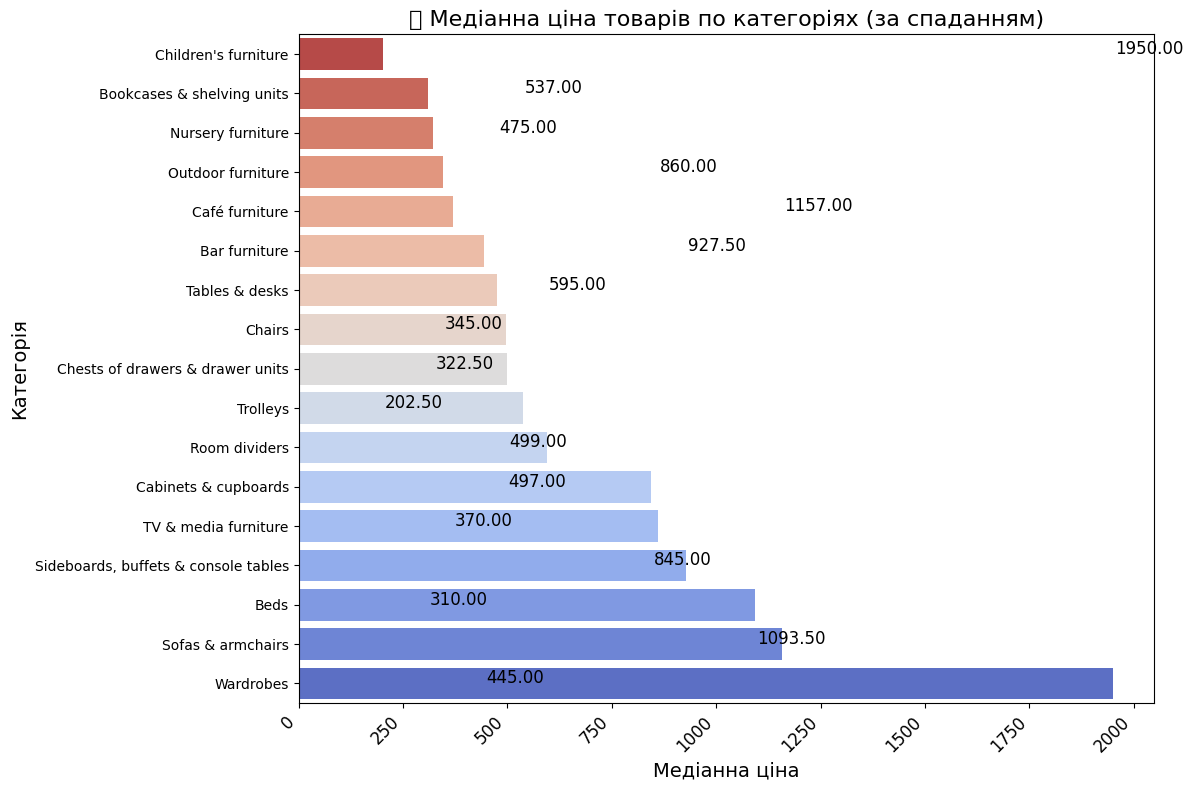

In [37]:
# Візуалізація медіанної ціни товарів по категоріям

# 🟢 Перевірка наявності колонок 'category' та 'price'
if 'category' in data.columns and 'price' in data.columns:
    # 📊 Розрахунок медіанної ціни товарів по категоріях
    median_price_by_category = data.groupby('category')['price'].median().reset_index()

    # 📉 Сортування категорій за спаданням медіанної ціни
    median_price_by_category = median_price_by_category.sort_values(by='price', ascending=False)

    # 🔹 Побудова графіка
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='price', y='category', data=median_price_by_category, palette="coolwarm")

    # 📌 Додавання заголовку та підписів
    plt.title('📊 Медіанна ціна товарів по категоріях (за спаданням)', fontsize=16)
    plt.xlabel('Медіанна ціна', fontsize=14)
    plt.ylabel('Категорія', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # 🏷️ Додавання числових підписів на стовпці
    for index, row in median_price_by_category.iterrows():
        ax.text(row['price'] + 5, index, f"{row['price']:.2f}", ha='left', fontsize=12, color='black')

    # 📈 Налаштування меж графіка
    plt.ylim(-0.5, len(median_price_by_category) - 0.5)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Увага! Відсутня одна з необхідних колонок ('category' або 'price').")

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\2525023069.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='designer', data=top_15_designers, palette="coolwarm")


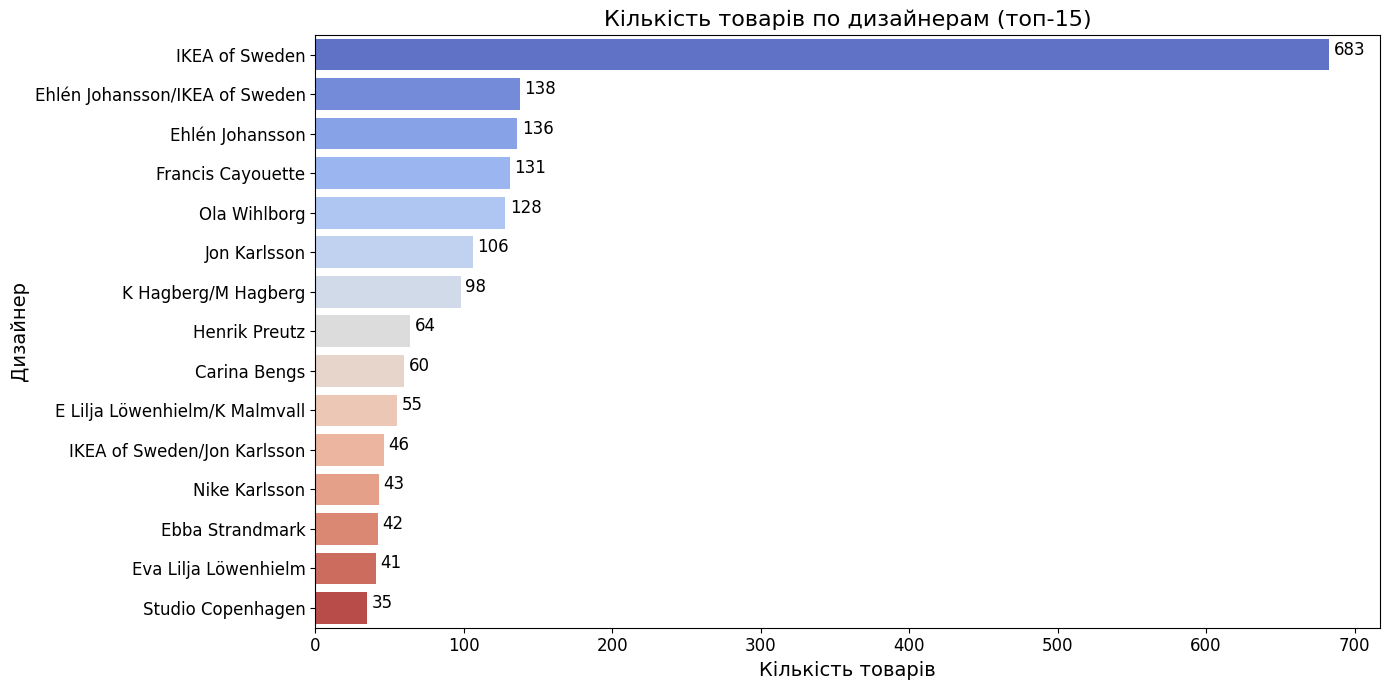

In [17]:
# Візуалізація кількості товарів по дизайнерам (топ-15)

# Перевірка, чи колонка 'designer' є в наборі даних
if 'designer' in data.columns:
    # Отримання топ-15 дизайнерів за кількістю товарів
    top_15_designers = data['designer'].value_counts().head(15).reset_index()
    top_15_designers.columns = ['designer', 'count']  # Перейменування колонок для зручності

    # Візуалізація
    plt.figure(figsize=(14, 7))
    sns.barplot(x='count', y='designer', data=top_15_designers, palette="coolwarm")

    # Додавання заголовку та підписів
    plt.title('Кількість товарів по дизайнерам (топ-15)', fontsize=16)
    plt.xlabel('Кількість товарів', fontsize=14)
    plt.ylabel('Дизайнер', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Додавання числових підписів до графіка
    for index, value in enumerate(top_15_designers['count']):
        plt.text(value + 3, index, str(int(value)), ha='left', fontsize=12)

    # Відображення графіка
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Увага! Колонка 'designer' відсутня у наборі даних.")

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\1293710570.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='designer', data=median_price_by_designer, palette="coolwarm")


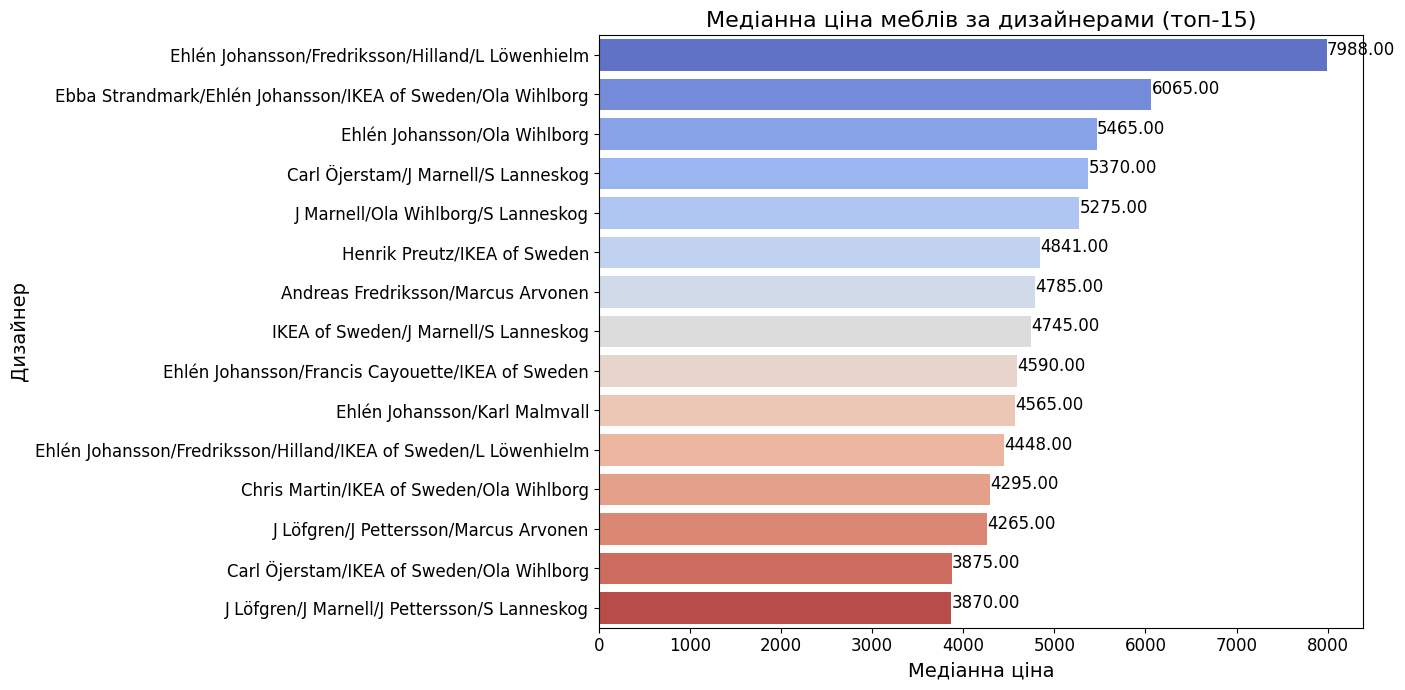

In [18]:
# Візуалізація медіанної ціни меблів за дизайнерами (топ-15)

# Перевірка наявності колонок 'designer' та 'price'
if 'designer' in data.columns and 'price' in data.columns:
    # Розрахунок медіанної ціни товарів по дизайнерам (топ-15)
    median_price_by_designer = data.groupby('designer')['price'].median().nlargest(15).reset_index()

    # Візуалізація
    plt.figure(figsize=(14, 7))
    sns.barplot(x='price', y='designer', data=median_price_by_designer, palette="coolwarm")

    # Додавання заголовку та підписів
    plt.title('Медіанна ціна меблів за дизайнерами (топ-15)', fontsize=16)
    plt.xlabel('Медіанна ціна', fontsize=14)
    plt.ylabel('Дизайнер', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Додавання числових значень на стовпцях
    for index, value in enumerate(median_price_by_designer['price']):
        plt.text(value + 3, index, f"{value:.2f}", ha='left', fontsize=12)

    # Відображення графіка
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Увага! Відсутня одна з необхідних колонок ('designer' або 'price').")

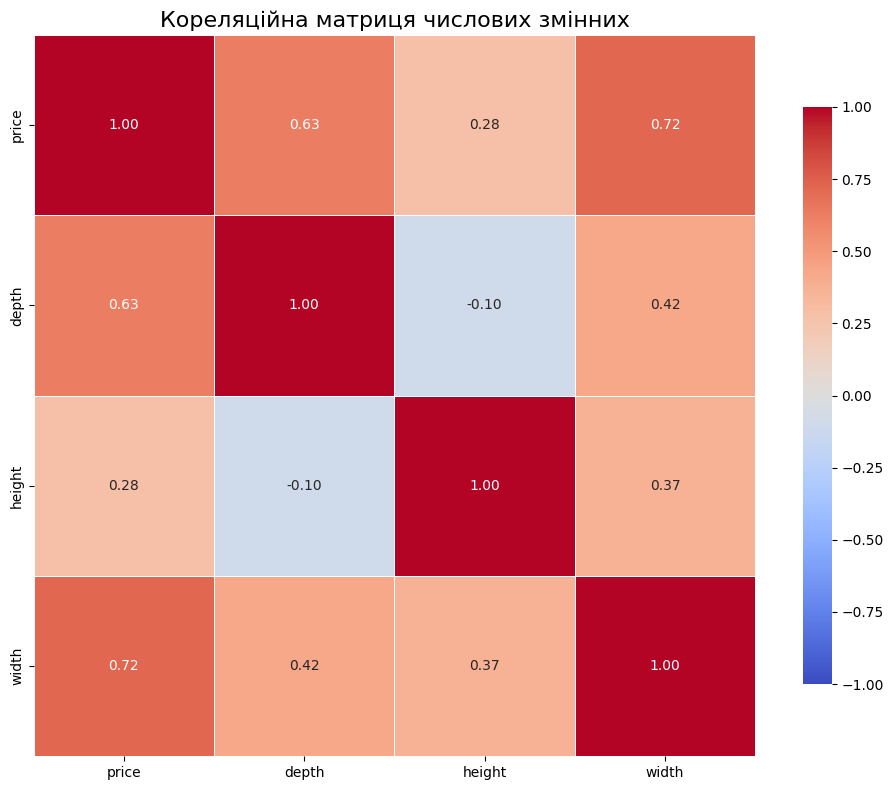

In [19]:
# Кореляційна матриця числових змінних (ціна та габарити)

# Перевірка наявності числових колонок у наборі даних
numeric_columns = ['price', 'depth', 'height', 'width']
missing_columns = [col for col in numeric_columns if col not in data.columns]

if missing_columns:
    print(f"⚠️ Відсутні необхідні колонки для кореляційної матриці: {', '.join(missing_columns)}")
else:
    # Розрахунок кореляційної матриці
    correlation_matrix = data[numeric_columns].corr()

    # Візуалізація кореляційної матриці
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,
        vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8}
    )

    # Додавання заголовку
    plt.title('Кореляційна матриця числових змінних', fontsize=16)

    # Відображення графіка
    plt.tight_layout()
    plt.show()

In [20]:
# 3. Гіпотези

# Гіпотеза 1: Вплив категорії товарів на кінцеву ціну меблів.

# Нульова гіпотеза (H₀): Категорія товару не впливає на кінцеву ціну меблів. Це означає, що середні ціни між категоріями не мають значущих відмінностей.
# Альтернативна гіпотеза (H₁): Категорія товару впливає на кінцеву ціну меблів. Це означає, що є статистично значущі відмінності у цінах між категоріями.
# Можливі альтернативні гіпотези: 
# 1. H₁a: Деякі категорії мають вищу середню ціну, ніж інші.
# 2. H₁b: Деякі категорії мають нижчу середню ціну.
# 3. H₁c: Ціна меблів змінюється нелінійно залежно від категорії.

In [21]:
# Перевірка наявності колонок
if 'category' in data.columns and 'price' in data.columns:
    print("🔍 Виконання тестів для гіпотези...")

    # 1️⃣ ANOVA тест
    model = ols('price ~ C(category)', data=data).fit()
    anova_results = sm.stats.anova_lm(model, typ=2)
    print("\n📊 ANOVA результати:")
    print(anova_results)

    # 2️⃣ Критерій Крускала-Уолліса (непараметричний тест)
    category_groups = [group["price"].dropna().values for _, group in data.groupby("category")]
    kruskal_stat, p_value_kruskal = stats.kruskal(*category_groups)
    print(f"\n🟠 Крускала-Уолліса тест: статистика = {kruskal_stat:.4f}, P-значення = {p_value_kruskal:.5e}")

    # 3️⃣ Тест Тьюкі (Tukey HSD) — для парних порівнянь
    tukey_results = pairwise_tukeyhsd(data['price'], data['category'])
    print("\n🔹 Тест Тьюкі (Post-hoc порівняння):")
    print(tukey_results)

    # Інтерпретація результатів
    if anova_results["PR(>F)"][0] < 0.05:
        print("✅ ANOVA показує, що категорія **впливає** на кінцеву ціну меблів.")
    else:
        print("❌ ANOVA показує, що категорія **не має значущого впливу** на кінцеву ціну меблів.")

    if p_value_kruskal < 0.05:
        print("✅ Критерій Крускала-Уолліса підтверджує значущу різницю між категоріями.")

else:
    print("⚠️ Відсутня одна з необхідних колонок ('category' або 'price').")

🔍 Виконання тестів для гіпотези...

📊 ANOVA результати:
                   sum_sq      df         F         PR(>F)
C(category)  9.805847e+08    16.0  37.83962  3.576901e-107
Residual     4.769838e+09  2945.0       NaN            NaN

🟠 Крускала-Уолліса тест: статистика = 548.9566, P-значення = 1.49239e-106

🔹 Тест Тьюкі (Post-hoc порівняння):
                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
               group1                               group2                 meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------------------------------------------------------------
                       Bar furniture                                 Beds   967.8795 0.0003   256.3991 1679.3599   True
                       Bar furniture           Bookcases & shelving units  -160.1371    1.0  -829.7021  509.4278  False
                       Bar furniture                 Ca

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\61995229.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results["PR(>F)"][0] < 0.05:


In [22]:
# Гіпотеза 2: Вплив габаритів меблів на їх кінцеву ціну.

# Нульова гіпотеза (H₀): Габарити меблів не впливають на кінцеву ціну. Це означає, що розміри (глибина, висота, ширина) не є значущими факторами ціноутворення.
# Альтернативна гіпотеза (H₁): Габарити меблів впливають на кінцеву ціну. Це означає, що є статистично значуща залежність між розмірами меблів та їхньою ціною.
# Можливі альтернативні гіпотези:
# 1. H₁a: Збільшення габаритів призводить до зростання ціни.
# 2. H₁b: Деякі габарити меблів знижують їх кінцеву ціну.
# 3. H₁c: Вплив габаритів змінюється залежно від типу меблів (взаємодія між категорією і розмірами).

In [23]:
# Перевірка наявності колонок
numeric_columns = ['price', 'depth', 'height', 'width']
missing_columns = [col for col in numeric_columns if col not in data.columns]

if missing_columns:
    print(f"⚠️ Відсутні необхідні колонки для аналізу: {', '.join(missing_columns)}")
else:
    print("🔍 Виконання тестів для гіпотези...")

    # 1️⃣ Лінійна регресія (оцінка впливу габаритів)
    model = ols('price ~ depth + height + width', data=data).fit()
    print("\n📊 Лінійна регресія:")
    print(model.summary())

    # 2️⃣ Спірменова кореляція (перевірка залежності)
    clean_data = data[numeric_columns].dropna()  # Видалення пропущених значень

    spearman_corr_depth, p_value_depth = stats.spearmanr(clean_data['depth'], clean_data['price'])
    spearman_corr_height, p_value_height = stats.spearmanr(clean_data['height'], clean_data['price'])
    spearman_corr_width, p_value_width = stats.spearmanr(clean_data['width'], clean_data['price'])

    print(f"\n🟠 Спірменова кореляція (оновлена):")
    print(f"Глибина: r = {spearman_corr_depth:.4f}, P-значення = {p_value_depth:.5e}")
    print(f"Висота: r = {spearman_corr_height:.4f}, P-значення = {p_value_height:.5e}")
    print(f"Ширина: r = {spearman_corr_width:.4f}, P-значення = {max(p_value_width, 1e-300):.5e}")  # Запобігання нульовому значенню

    # 3️⃣ ANCOVA (аналіз взаємодії категорії з розмірами)
    if 'category' in data.columns:
        model_ancova = ols('price ~ depth + height + width + C(category)', data=data).fit()
        ancova_results = sm.stats.anova_lm(model_ancova, typ=2)
        print("\n🔹 ANCOVA тест:")
        print(ancova_results)
    else:
        print("⚠️ Колонка 'category' відсутня, ANCOVA не виконано.")

🔍 Виконання тестів для гіпотези...

📊 Лінійна регресія:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1302.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:10:07   Log-Likelihood:                -12952.
No. Observations:                1602   AIC:                         2.591e+04
Df Residuals:                    1598   BIC:                         2.593e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [24]:
# 4. Машинне навчання

# 1️⃣ Видалення неінформативних колонок
drop_columns = ['item_id', 'old_price', 'sellable_online', 'name', 'link', 'short_description']
data_cleaned = data.drop(columns=drop_columns, errors='ignore')

# 2️⃣ Групування дизайнерів та категорій для зменшення кількості фіч
data_cleaned['category_designer'] = data_cleaned['category'] + "_" + data_cleaned['designer']

# 3️⃣ Визначення числових та категоріальних змінних
numeric_features = ['depth', 'height', 'width']
categorical_features = ['category_designer', 'other_colors']

# 4️⃣ Трансформери для числових даних
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заповнення пропущених значень медіаною
    ('scaler', StandardScaler())  # Нормалізація даних
])

# 5️⃣ Трансформери для категоріальних даних
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Кодування категорій
])

# 6️⃣ Об'єднання трансформерів у препроцесор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [25]:
# Видалення непотрібних колонок
drop_columns = ['item_id', 'old_price', 'sellable_online', 'name', 'link', 'short_description']
data_cleaned = data.drop(columns=drop_columns, errors='ignore')

# Формування X (предикторів) та y (цільової змінної)
X = data_cleaned.drop(columns=['price'])
y = data_cleaned['price']

# Розподіл на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Розмір тренувальної вибірки: {X_train.shape}, Розмір тестової вибірки: {X_test.shape}")

✅ Розмір тренувальної вибірки: (2369, 7), Розмір тестової вибірки: (593, 7)


In [26]:
# Модель 1: Лінійна регресія з крос-валідацією

# 1️⃣ Видалення нерелевантних колонок
drop_columns = ['item_id', 'old_price', 'sellable_online', 'name', 'link', 'short_description']
data_cleaned = data.drop(columns=drop_columns, errors='ignore')

# 2️⃣ Переконатися, що `category_designer` правильно створено
if 'category' in data_cleaned.columns and 'designer' in data_cleaned.columns:
    data_cleaned['category_designer'] = data_cleaned['category'].astype(str) + "_" + data_cleaned['designer'].astype(str)

# 3️⃣ Перевірка, чи колонка існує перед препроцесингом
print("✅ Перевірка наявності 'category_designer' у DataFrame:", 'category_designer' in data_cleaned.columns)

# 4️⃣ Визначення ознак
numeric_features = ['depth', 'height', 'width']
categorical_features = ['category_designer', 'other_colors'] if 'category_designer' in data_cleaned.columns else ['other_colors']

# 5️⃣ Трансформери
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 6️⃣ Розділення на X та y
X = data_cleaned.drop(columns=['price'])
y = data_cleaned['price']

# 7️⃣ Розділення на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8️⃣ Переконатися, що `category_designer` входить у `X_train`
print("✅ Перевірка 'category_designer' у X_train:", 'category_designer' in X_train.columns)

# 9️⃣ Побудова моделі лінійної регресії з препроцесором
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# 🔟 Тренування моделі
model_lr.fit(X_train, y_train)

# 11️⃣ Прогнозування
y_pred_lr = model_lr.predict(X_test)

# 12️⃣ Оцінка продуктивності моделі
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"📊 Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.4f}")

# 13️⃣ Крос-валідація
cv_scores_lr = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='r2')

print(f"📊 Крос-валідація R²: {np.mean(cv_scores_lr):.4f} ± {np.std(cv_scores_lr):.4f}")

✅ Перевірка наявності 'category_designer' у DataFrame: True
✅ Перевірка 'category_designer' у X_train: True
📊 Linear Regression - MAE: 486.25, RMSE: 740.76, R²: 0.7087
📊 Крос-валідація R²: 0.7062 ± 0.0258


In [27]:
# Модель 2: Decision Tree Regressor з оптимізацією

# Побудова моделі дерева рішень із гіперпараметричним пошуком
param_grid = {
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

# Створення пайплайну
model_dtr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Гіперпараметричний пошук
grid_search_dtr = GridSearchCV(model_dtr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_dtr.fit(X_train, y_train)

# Найкращі параметри
print(f"📊 Найкращі параметри Decision Tree: {grid_search_dtr.best_params_}")

# Прогнозування
y_pred_dtr = grid_search_dtr.best_estimator_.predict(X_test)

# Оцінка моделі
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
rmse_dtr = np.sqrt(mean_squared_error(y_test, y_pred_dtr))
r2_dtr = r2_score(y_test, y_pred_dtr)

# Крос-валідація
cv_scores = cross_val_score(grid_search_dtr.best_estimator_, X_train, y_train, cv=5, scoring='r2')

print(f"📊 Decision Tree - MAE: {mae_dtr:.2f}, RMSE: {rmse_dtr:.2f}, R²: {r2_dtr:.4f}")
print(f"📊 Крос-валідація R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

📊 Найкращі параметри Decision Tree: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
📊 Decision Tree - MAE: 412.68, RMSE: 692.02, R²: 0.7457
📊 Крос-валідація R²: 0.6925 ± 0.0498


In [28]:
# Модель 3: Random Forest Regressor

# Параметри для оптимізації
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

# Побудова моделі з пошуком найкращих параметрів
model_rfr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid_search_rfr = GridSearchCV(model_rfr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_rfr.fit(X_train, y_train)

# Найкращі параметри
print(f"📊 Найкращі параметри Random Forest: {grid_search_rfr.best_params_}")

# Прогнозування
y_pred_rfr = grid_search_rfr.best_estimator_.predict(X_test)

# Оцінка моделі
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r2_rfr = r2_score(y_test, y_pred_rfr)

# Крос-валідація
cv_scores = cross_val_score(grid_search_rfr.best_estimator_, X_train, y_train, cv=5, scoring='r2')

print(f"📊 Random Forest - MAE: {mae_rfr:.2f}, RMSE: {rmse_rfr:.2f}, R²: {r2_rfr:.4f}")
print(f"📊 Крос-валідація R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

📊 Найкращі параметри Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
📊 Random Forest - MAE: 375.92, RMSE: 629.25, R²: 0.7898
📊 Крос-валідація R²: 0.7527 ± 0.0416


In [29]:
# Модель 4: Gradient Boosting Regressor з GridSearchCV

# Параметри для оптимізації
param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

# Побудова моделі з пошуком найкращих параметрів
model_gbr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_search_gbr = GridSearchCV(model_gbr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)

# Найкращі параметри
print(f"📊 Найкращі параметри Gradient Boosting: {grid_search_gbr.best_params_}")

# Прогнозування
y_pred_gbr = grid_search_gbr.best_estimator_.predict(X_test)

# Оцінка моделі
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

# Крос-валідація
cv_scores = cross_val_score(grid_search_gbr.best_estimator_, X_train, y_train, cv=5, scoring='r2')

print(f"📊 Gradient Boosting - MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}, R²: {r2_gbr:.4f}")
print(f"📊 Крос-валідація R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

📊 Найкращі параметри Gradient Boosting: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500}
📊 Gradient Boosting - MAE: 374.30, RMSE: 611.45, R²: 0.8015
📊 Крос-валідація R²: 0.7823 ± 0.0340


In [30]:
# Модель 5: KNeighbors Regressor з оптимізацією

# Параметри для оптимізації
param_grid = {
    'model__n_neighbors': [3, 5, 8, 15],
    'model__weights': ['uniform', 'distance']
}

# Побудова моделі з пошуком оптимальних параметрів
model_knr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor())
])

grid_search_knr = GridSearchCV(model_knr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_knr.fit(X_train, y_train)

# Найкращі параметри
print(f"📊 Найкращі параметри KNeighbors: {grid_search_knr.best_params_}")

# Прогнозування
y_pred_knr = grid_search_knr.best_estimator_.predict(X_test)

# Оцінка моделі
mae_knr = mean_absolute_error(y_test, y_pred_knr)
rmse_knr = np.sqrt(mean_squared_error(y_test, y_pred_knr))
r2_knr = r2_score(y_test, y_pred_knr)

# Крос-валідація
cv_scores = cross_val_score(grid_search_knr.best_estimator_, X_train, y_train, cv=5, scoring='r2')

print(f"📊 KNeighbors - MAE: {mae_knr:.2f}, RMSE: {rmse_knr:.2f}, R²: {r2_knr:.4f}")
print(f"📊 Крос-валідація R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

📊 Найкращі параметри KNeighbors: {'model__n_neighbors': 15, 'model__weights': 'distance'}
📊 KNeighbors - MAE: 393.45, RMSE: 660.60, R²: 0.7683
📊 Крос-валідація R²: 0.7613 ± 0.0243


✅ Перевірка наявності 'category_designer' у DataFrame: True
📊 XGBoost - MAE: 392.23, RMSE: 610.17, R²: 0.8023
📊 Крос-валідація R²: 0.7795 ± 0.0143


C:\Users\behun\AppData\Local\Temp\ipykernel_23496\1998173386.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="coolwarm")


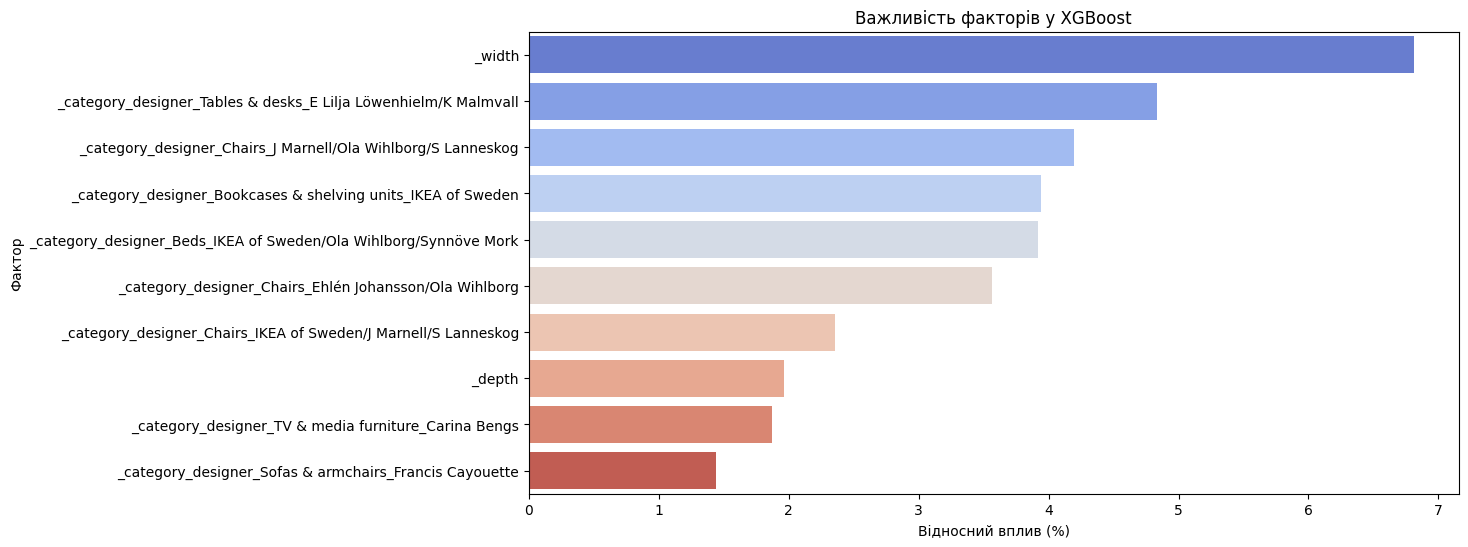

In [31]:
# Модель 6: XGBoost

# 1️⃣ Видалення зайвих колонок
drop_columns = ['item_id', 'old_price', 'sellable_online', 'name', 'link', 'short_description']
data_cleaned = data.drop(columns=drop_columns, errors='ignore')

# 2️⃣ Створення 'category_designer'
if 'category' in data_cleaned.columns and 'designer' in data_cleaned.columns:
    data_cleaned['category_designer'] = data_cleaned['category'].astype(str) + "_" + data_cleaned['designer'].astype(str)

# 3️⃣ Перевірка існування колонок перед препроцесингом
print("✅ Перевірка наявності 'category_designer' у DataFrame:", 'category_designer' in data_cleaned.columns)

# 4️⃣ Визначення ознак
numeric_features = ['depth', 'height', 'width']
categorical_features = ['category_designer', 'other_colors'] if 'category_designer' in data_cleaned.columns else ['other_colors']

# 5️⃣ Трансформери
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 6️⃣ Розділення на X та y
X = data_cleaned.drop(columns=['price'])
y = data_cleaned['price']

# 7️⃣ Розділення на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8️⃣ Препроцесинг даних
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 9️⃣ Створення та тренування XGBoost
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train_transformed, y_train)

# 🔟 Прогнозування
y_pred_xgb = model_xgb.predict(X_test_transformed)

# 11️⃣ Оцінка продуктивності
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# 12️⃣ Крос-валідація
cv_scores = cross_val_score(model_xgb, X_train_transformed, y_train, cv=5, scoring='r2')

print(f"📊 XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.4f}")
print(f"📊 Крос-валідація R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# 13️⃣ Аналіз важливості факторів
feature_importances = model_xgb.feature_importances_

# Отримання правильних назв ознак після препроцесингу
feature_names = preprocessor.get_feature_names_out()

# Очищення назв ознак, щоб прибрати префікси трансформерів
feature_names = [name.split("_", 1)[-1] for name in feature_names]

# Переконатися, що довжини збігаються перед створенням DataFrame
if len(feature_names) == len(feature_importances):
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

    # Візуалізація
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="coolwarm")
    plt.title('Важливість факторів у XGBoost')
    plt.xlabel('Відносний вплив (%)')
    plt.ylabel('Фактор')
    plt.show()
else:
    print("❌ Кількість назв ознак не збігається з важливістю факторів!")
    print(f"Кількість назв ознак: {len(feature_names)}, Кількість важливостей: {len(feature_importances)}")

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\589090612.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', cmap='coolwarm')


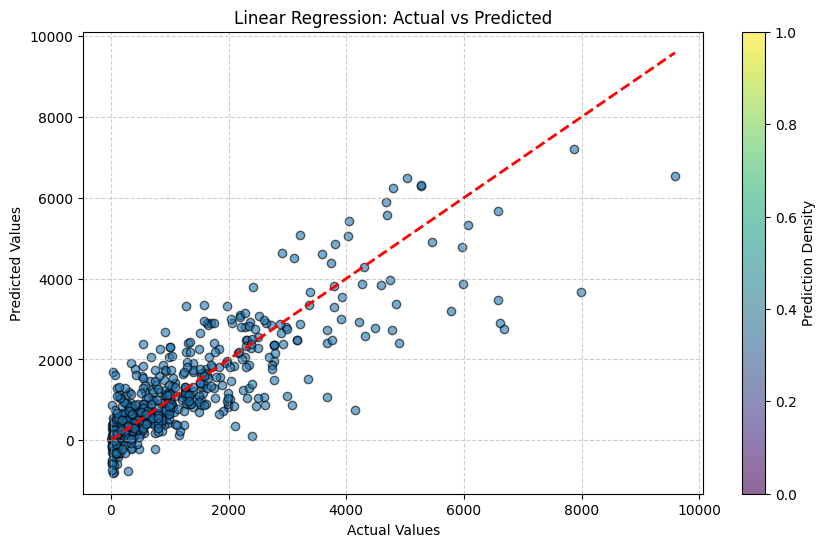

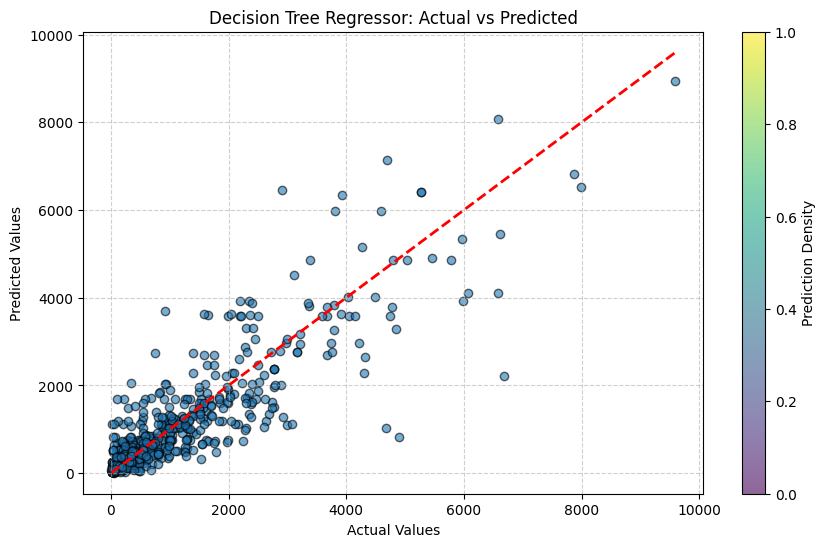

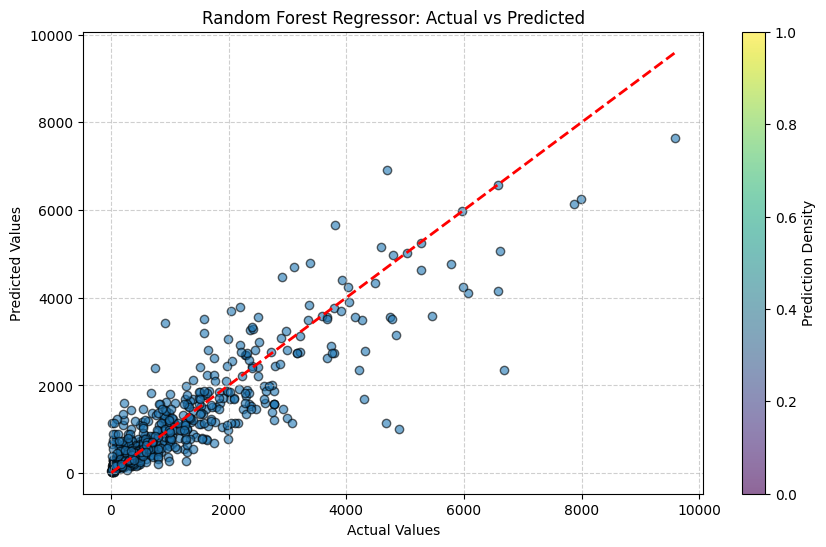

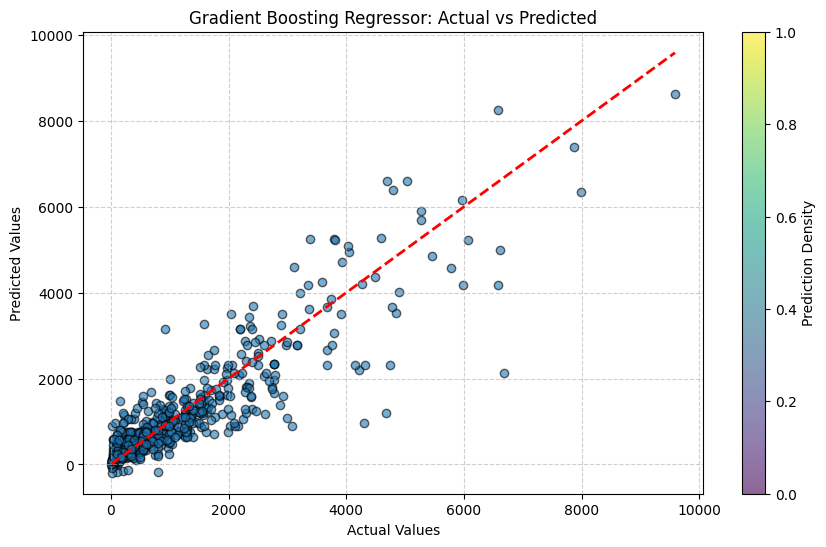

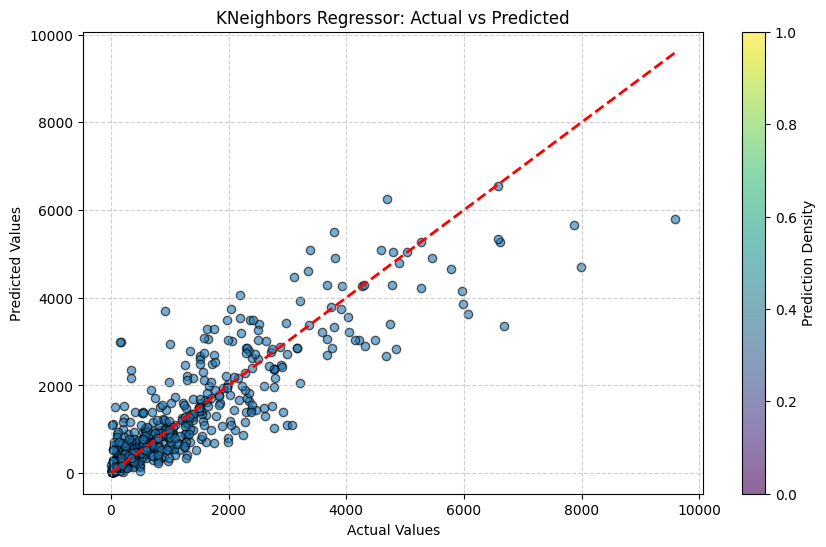

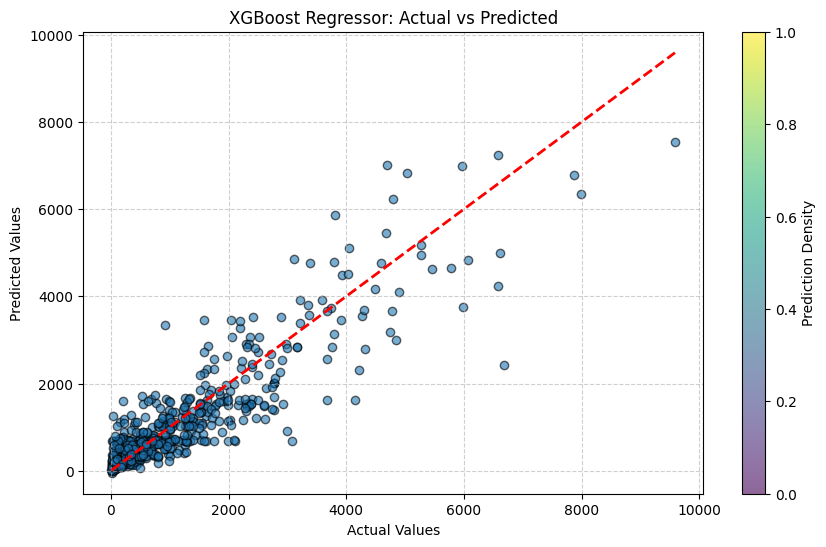

In [32]:
# Функція для візуалізації прогнозів
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', cmap='coolwarm')
    plt.colorbar(label='Prediction Density')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: Actual vs Predicted')

    # Лінія ідеального прогнозу
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Візуалізація для всіх моделей
plot_predictions(y_test, y_pred_lr, "Linear Regression")
plot_predictions(y_test, y_pred_dtr, "Decision Tree Regressor")
plot_predictions(y_test, y_pred_rfr, "Random Forest Regressor")
plot_predictions(y_test, y_pred_gbr, "Gradient Boosting Regressor")
plot_predictions(y_test, y_pred_knr, "KNeighbors Regressor")
plot_predictions(y_test, y_pred_xgb, "XGBoost Regressor")

In [33]:
# 🟢 Результати всіх моделей
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "MAE": [mae_lr, mae_dtr, mae_rfr, mae_xgb], 
    "RMSE": [rmse_lr, rmse_dtr, rmse_rfr, rmse_xgb], 
    "R²": [r2_lr, r2_dtr, r2_rfr, r2_xgb]
})

# 🟢 Відображення результатів
print(results.sort_values(by="R²", ascending=False))

               Model         MAE        RMSE        R²
3            XGBoost  392.228355  610.166051  0.802335
2      Random Forest  375.924767  629.254168  0.789774
1      Decision Tree  412.681552  692.015508  0.745747
0  Linear Regression  486.248930  740.761885  0.708666


Fitting 5 folds for each of 54 candidates, totalling 270 fits
✅ Найкращі параметри: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1}
📊 Найкраще значення R² з Grid Search: 0.7829
📊 XGBoost Regressor (Best) - MAE: 370.83, RMSE: 586.60, R²: 0.8173
📊 Крос-валідація R²: 0.7829 ± 0.0226


C:\Users\behun\AppData\Local\Temp\ipykernel_23496\103277350.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df.index, palette="coolwarm")
C:\Users\behun\PycharmProjects\lesson1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


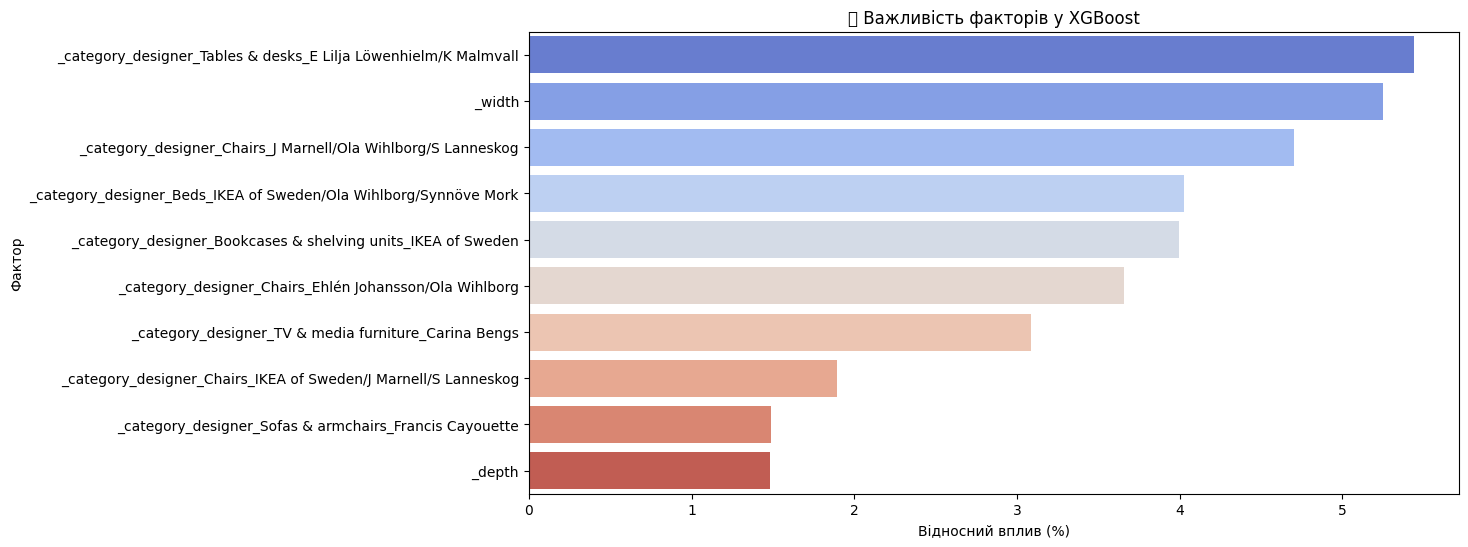

In [34]:
# 🟢 1️⃣ Видалення нерелевантних колонок
drop_columns = ['name', 'link', 'short_description', 'sellable_online', 'item_id', 'old_price']
data_cleaned = data.drop(columns=drop_columns, errors='ignore')

# 🟢 2️⃣ Формування `category_designer`
if 'category' in data_cleaned.columns and 'designer' in data_cleaned.columns:
    data_cleaned['category_designer'] = data_cleaned['category'].astype(str) + "_" + data_cleaned['designer'].astype(str)

# 🟢 3️⃣ Визначення ознак
numeric_features = ['depth', 'height', 'width']
categorical_features = ['category_designer', 'other_colors']

# 🟢 4️⃣ Препроцесинг
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 🟢 5️⃣ Розділення на X та y
X = data_cleaned.drop(columns=['price'])
y = data_cleaned['price']

# 🟢 6️⃣ Розділення на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🟢 7️⃣ Перетворення X_train та X_test перед Grid Search
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 🟢 8️⃣ **Параметри для Grid Search XGBoost**
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [6, 10, 15],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 1]  
}

# 🟢 9️⃣ Побудова моделі XGBoost
model_xgb = XGBRegressor(random_state=42)

# 🟢 🔟 Виконання Grid Search для XGBoost
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=2)
grid_search.fit(X_train_transformed, y_train)

# 🟢 11️⃣ Найкращі параметри та оцінка
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"✅ Найкращі параметри: {best_params}")
print(f"📊 Найкраще значення R² з Grid Search: {best_score:.4f}")

# 🟢 12️⃣ Прогнозування
best_model_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_model_xgb.predict(X_test_transformed)

# 🟢 13️⃣ Оцінка продуктивності
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print(f"📊 XGBoost Regressor (Best) - MAE: {mae_best_xgb:.2f}, RMSE: {rmse_best_xgb:.2f}, R²: {r2_best_xgb:.4f}")

# 🟢 14️⃣ Крос-валідація для XGBoost
cv_scores_xgb = cross_val_score(best_model_xgb, X_train_transformed, y_train, cv=5, scoring='r2')
print(f"📊 Крос-валідація R²: {np.mean(cv_scores_xgb):.4f} ± {np.std(cv_scores_xgb):.4f}")

# 🟢 15️⃣ Аналіз важливості факторів
feature_importances = best_model_xgb.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Очищення назв ознак
feature_names = [name.split("_", 1)[-1] for name in feature_names]

# Групування факторів (категорія + дизайнер)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df = importance_df.groupby('Feature').sum().sort_values(by='Importance', ascending=False).head(10)

# 🟢 16️⃣ Візуалізація важливості факторів
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df.index, palette="coolwarm")
plt.title('📊 Важливість факторів у XGBoost')
plt.xlabel('Відносний вплив (%)')
plt.ylabel('Фактор')
plt.show()

📊 Крос-валідація R²: [0.80784223 0.78671427 0.78977339 0.74024    0.78992158]
✅ Середнє R²: 0.7829
📉 Стандартне відхилення R²: 0.0226


C:\Users\behun\AppData\Local\Temp\ipykernel_23496\3171469175.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(y_test, y_pred_best_xgb, alpha=0.6, edgecolors='k', cmap='coolwarm')
C:\Users\behun\PycharmProjects\lesson1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


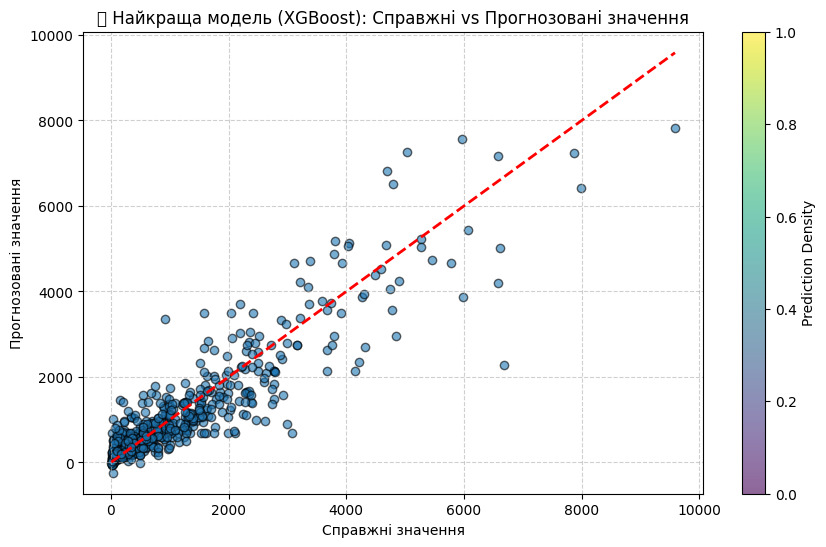

In [35]:
# 🟢 1️⃣ Крос-валідація для XGBoost
cv_scores_xgb = cross_val_score(best_model_xgb, X_train_transformed, y_train, cv=5, scoring='r2', verbose=1)

# 🟢 2️⃣ Визначення статистичних показників
mean_score = np.mean(cv_scores_xgb)
std_score = np.std(cv_scores_xgb)

# 🟢 3️⃣ Виведення результатів
print(f"📊 Крос-валідація R²: {cv_scores_xgb}")
print(f"✅ Середнє R²: {mean_score:.4f}")
print(f"📉 Стандартне відхилення R²: {std_score:.4f}")

# 🟢 4️⃣ Візуалізація прогнозів для XGBoost
plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_test, y_pred_best_xgb, alpha=0.6, edgecolors='k', cmap='coolwarm')
plt.colorbar(label='Prediction Density')

# Лінія ідеального прогнозу (червона пунктирна)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2)

# Налаштування графіка
plt.xlabel('Справжні значення')
plt.ylabel('Прогнозовані значення')
plt.title('📊 Найкраща модель (XGBoost): Справжні vs Прогнозовані значення')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

C:\Users\behun\AppData\Local\Temp\ipykernel_23496\1736862149.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_df['Importance'], y=features_df.index, palette="coolwarm")
C:\Users\behun\PycharmProjects\lesson1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


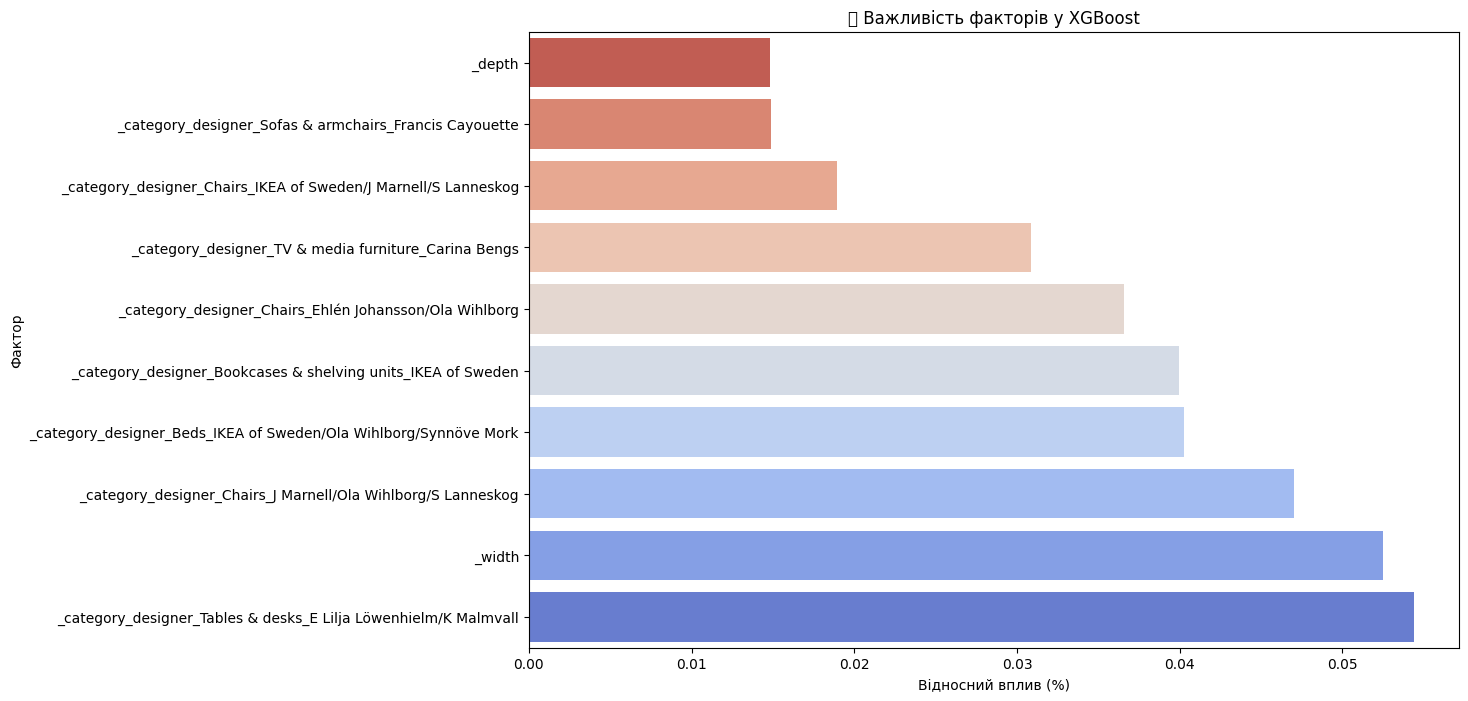

In [36]:
# 🟢 1️⃣ Визначення важливості фічей для XGBoost
feature_importances = best_model_xgb.feature_importances_

# 🟢 2️⃣ Отримання назв ознак із препроцесора
feature_names = preprocessor.get_feature_names_out()

# 🟢 3️⃣ Створення DataFrame для важливості фічей
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 🟢 4️⃣ Групування категорійних змінних (наприклад, category + designer)
features_df['Feature'] = features_df['Feature'].apply(lambda x: x.split("_", 1)[-1])

# 🟢 5️⃣ Сортування за важливістю
features_df = features_df.groupby('Feature').sum().sort_values(by='Importance', ascending=False).head(10)

# 🟢 6️⃣ Візуалізація важливості фічей
plt.figure(figsize=(12, 8))
sns.barplot(x=features_df['Importance'], y=features_df.index, palette="coolwarm")
plt.xlabel('Відносний вплив (%)')
plt.ylabel('Фактор')
plt.title('📊 Важливість факторів у XGBoost')
plt.gca().invert_yaxis()
plt.show()